In [1]:
# Requires 0.24
import os
import sys
sys.path.insert(1,os.path.abspath('../0. Not_git/Sources/scikit-learn/0.24.0'))
import sklearn
print(sklearn.__version__)
#this will be 0.24.2 

0.24.0


### Load Data

In [2]:
import pandas as pd

# Input path and filename
path = '../5. Master_thesis/Datasets/Output_files/'

# Load files into a pandas dataframes
file = path + 'Orders.xlsx'
df = pd.concat(pd.read_excel(file, sheet_name=None), ignore_index=True)

# Set index
df = df.set_index("Date").asfreq('MS')

# Dependant variable 
dep_var = 'Orders_diff'

In [3]:
df

,Orders
Date,
2006-01-01,1124
2006-02-01,1079
2006-03-01,1210
2006-04-01,1147
2006-05-01,1001
...,...
2022-08-01,254
2022-09-01,228
2022-10-01,188


In [4]:
df['Orders_diff'] = df.Orders.diff(1)

In [5]:
df = df.dropna()

In [6]:
df

,Orders,Orders_diff
Date,,
2006-02-01,1079,-45.0
2006-03-01,1210,131.0
2006-04-01,1147,-63.0
2006-05-01,1001,-146.0
2006-06-01,1087,86.0
...,...,...
2022-08-01,254,136.0
2022-09-01,228,-26.0
2022-10-01,188,-40.0


In [7]:
df.drop(['Orders'], axis=1, inplace=True)

C:\Users\ne74255\AppData\Local\Temp/ipykernel_964/2563057938.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['Orders'], axis=1, inplace=True)


In [8]:
df

,Orders_diff
Date,
2006-02-01,-45.0
2006-03-01,131.0
2006-04-01,-63.0
2006-05-01,-146.0
2006-06-01,86.0
...,...
2022-08-01,136.0
2022-09-01,-26.0
2022-10-01,-40.0


### Split Data

In [9]:
# Split data
steps = 36  # Number of months of testing
train = df[:-steps]
test  = df[-steps:]

print(f"Dataset length : (n={len(df)})")
print(f"Train dates    : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Test dates     : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

start = train.index.min()
end = df.index.max()
start_test = test.index.min()

start, end, start_test

Dataset length : (n=203)
Train dates    : 2006-02-01 00:00:00 --- 2019-12-01 00:00:00  (n=167)
Test dates     : 2020-01-01 00:00:00 --- 2022-12-01 00:00:00  (n=36)


(Timestamp('2006-02-01 00:00:00', freq='MS'),
 Timestamp('2022-12-01 00:00:00', freq='MS'),
 Timestamp('2020-01-01 00:00:00', freq='MS'))

In [10]:
train.shape, test.shape

((167, 1), (36, 1))

### Scoring function

In [11]:
# Importing the metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Importing the modules
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.graph_objs as go

metrics = pd.DataFrame()

def scoring(model_name, y_true, y_pred):
    
    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)                      # MAE (Mean Absolute Error)
    mse = mean_squared_error(y_true, y_pred)                       # MSE (Mean Squared Error)
    rmse = math.sqrt(mse)                                          # RMSE (Root Mean Squared Error)
    r2 = r2_score(y_true, y_pred)                                  # R2 (R-squared - Coeficient of determination)                           
    mape = np.mean(np.abs((y_true - y_pred) /y_true)) * 100        # MAPE
    accuracy = 100 - mape                                          # Accuracy

    # Append metrics for summary
    metrics[model_name] = [mae, mse, rmse, r2, mape, accuracy]
    metrics.index = ['Mean Absolute Error', 
                    'Mean Squared Error', 
                    'Root Mean Squared Error',
                    'R^2',
                    'Mean Absolute Percentage Error',
                    'Accuracy']
    
    # Print metrics  
    print(model_name, 'Model Performance:')                             # Model name
    print('Mean Absolute Error: {:0.2f}.'.format(mae))                  # MAE
    print('Mean Squared Error: {:0.2f}.'.format(mse))                   # MSE
    print('Root Mean Squared Error: {:0.2f}.'.format(rmse))             # RMSE  
    print('R^2 Score = {:0.2f}.'.format(r2))                            # R2
    print('Mean Absolute Percentage Error: {:0.2f}%.'.format(mape))     # MAPE 
    print('Accuracy = {:0.2f}%.'.format(accuracy))                      # Accuracy

    df = pd.DataFrame(y_true)
        
    # Plot Actual values vs predicted values
    fig= go.Figure()
    fig.add_trace(go.Scatter(dict(x=df.index, y=y_true, mode='lines+markers', name= 'Actual')))
    fig.add_trace(go.Scatter(dict(x=df.index, y=y_pred, mode='lines+markers', name= 'Predicted')))
    fig.update_layout(title=go.layout.Title(
        text='Actual vs Predictions with ' + model_name,
        xref='paper',x=0),
        margin=dict(l=10, r=0, t=50, b=50),
    xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text='Date')),
    yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text='Cars')))
    fig.show() 

def plot_time_series(preds):

    fig= go.Figure()
    fig.add_trace(go.Scatter(dict(x=train.index, y=train[dep_var], mode='lines+markers', name= 'Train')))
    fig.add_trace(go.Scatter(dict(x=test.index, y=test[dep_var], mode='lines+markers', name= 'Test')))
    fig.add_trace(go.Scatter(dict(x=test.index, y=preds, mode='lines+markers', name= 'Forecast')))
    fig.update_layout(title=go.layout.Title(
        text='Actual vs Predictions',
        xref='paper',x=0),
        margin=dict(l=10, r=0, t=50, b=50),
    xaxis=go.layout.XAxis(title=go.layout.xaxis.Title(text='Date')),
    yaxis=go.layout.YAxis(title=go.layout.yaxis.Title(text='Cars')))
    fig.show() 

### Models

In [12]:
# Autoregressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg

# Models
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor 
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor

# Hyperparameters
#et_params = [{"C":0.01}, {"C":0.1}, {"C":1}, {"C":10}]
et_params = [{}]
xgb_params = [{}]
gb_params = [{}]
rf_params = [{}]
ab_params = [{}]
lgbm_params = [{}]
dt_params = [{}]

modelclasses = [
    ["Extra Tree", ExtraTreesRegressor, et_params],
    ["XGBoost", XGBRegressor, xgb_params],
    ["Gradient Boosting", GradientBoostingRegressor, gb_params],
    ["Random Forest", RandomForestRegressor, rf_params],
    ["Ada Boost", AdaBoostRegressor, ab_params],
    ["LightGBM", LGBMRegressor, lgbm_params],
    ["Decision Tree", DecisionTreeRegressor, dt_params]
]

number_of_lags = 12

for model_name, Model, params_list in modelclasses:
    for params in params_list:

        # Create forecaster
        forecaster = ForecasterAutoreg(
                regressor = Model(**params),
                lags = number_of_lags
        )
        # Fit model
        forecaster.fit(y=train[dep_var])
        
        # Predict
        preds = forecaster.predict(steps=steps)

        # Score
        scoring(model_name, test[dep_var], preds) 
        
        # Plot whole TS
        plot_time_series(preds)    

Extra Tree Model Performance:
Mean Absolute Error: 91.69.
Mean Squared Error: 14777.31.
Root Mean Squared Error: 121.56.
R^2 Score = -0.28.
Mean Absolute Percentage Error: 250.76%.
Accuracy = -150.76%.


XGBoost Model Performance:
Mean Absolute Error: 128.82.
Mean Squared Error: 25634.21.
Root Mean Squared Error: 160.11.
R^2 Score = -1.22.
Mean Absolute Percentage Error: 331.25%.
Accuracy = -231.25%.


Gradient Boosting Model Performance:
Mean Absolute Error: 83.78.
Mean Squared Error: 11370.05.
Root Mean Squared Error: 106.63.
R^2 Score = 0.01.
Mean Absolute Percentage Error: 215.19%.
Accuracy = -115.19%.


Random Forest Model Performance:
Mean Absolute Error: 86.10.
Mean Squared Error: 12431.10.
Root Mean Squared Error: 111.49.
R^2 Score = -0.08.
Mean Absolute Percentage Error: 219.89%.
Accuracy = -119.89%.


Ada Boost Model Performance:
Mean Absolute Error: 109.94.
Mean Squared Error: 20121.32.
Root Mean Squared Error: 141.85.
R^2 Score = -0.75.
Mean Absolute Percentage Error: 276.92%.
Accuracy = -176.92%.


LightGBM Model Performance:
Mean Absolute Error: 119.85.
Mean Squared Error: 22820.80.
Root Mean Squared Error: 151.07.
R^2 Score = -0.98.
Mean Absolute Percentage Error: 459.26%.
Accuracy = -359.26%.


Decision Tree Model Performance:
Mean Absolute Error: 122.44.
Mean Squared Error: 21657.28.
Root Mean Squared Error: 147.16.
R^2 Score = -0.88.
Mean Absolute Percentage Error: 432.50%.
Accuracy = -332.50%.


In [13]:
metrics

,Extra Tree,XGBoost,Gradient Boosting,Random Forest,Ada Boost,LightGBM,Decision Tree
Mean Absolute Error,91.689167,128.820001,83.783836,86.104722,109.936995,119.849301,122.444444
Mean Squared Error,14777.314336,25634.211083,11370.054380,12431.101692,20121.322207,22820.797622,21657.277778
Root Mean Squared Error,121.561977,160.106874,106.630457,111.494851,141.849646,151.065541,147.164119
R^2,-0.281978,-1.223848,0.013612,-0.078437,-0.745588,-0.979776,-0.878837
Mean Absolute Percentage Error,250.758748,331.253074,215.188738,219.890720,276.924319,459.257602,432.496162
Accuracy,-150.758748,-231.253074,-115.188738,-119.890720,-176.924319,-359.257602,-332.496162


### Gradient Boosting

In [14]:
# Instantiate the regressor
model = GradientBoostingRegressor()

# Create forecaster
best_forecaster = ForecasterAutoreg(
                regressor = GradientBoostingRegressor(),
                lags      = number_of_lags
             )

# Train forecaster
best_forecaster.fit(y=train[dep_var])
best_forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor() 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
Transformer for y: None 
Transformer for exog: None 
Window size: 12 
Weight function included: False 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('2006-02-01 00:00:00'), Timestamp('2019-12-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2023-02-13 23:31:24 
Last fit date: 2023-02-13 23:31:24 
Skforecast version: 0.6.0 
Pytho

#### Hyperparameter Tuning

In [15]:
# Hyperparameter Grid search
from skforecast.model_selection import grid_search_forecaster

forecaster = ForecasterAutoreg(
                regressor = LGBMRegressor(),
                lags      = 12                  # This value is replaced in the gridsearch
             )

lags_grid = [3,6,12]

# Set hyperparameters possibilities for model tuning
lgbm_n_estimators = [10, 50, 100]
lgbm_max_depth = [4, 6, 8]
lgbm_num_leaves = [3, 5, 7]
lgbm_learning_rate = [0.01, 0.1, 0.3]
lgbm_subsample = [0.3, 0.2, 0.1]

# Create the grid
param_grid = {'n_estimators': lgbm_n_estimators,
            'max_depth': lgbm_max_depth,
            'num_leaves': lgbm_num_leaves,
            'learning_rate': lgbm_learning_rate,
            'subsample': lgbm_learning_rate
           }

grid_results = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = train[dep_var],                        
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
                    )

Number of models compared: 729.


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:46<00:00, 15.48s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 10, 'num_leaves': 7, 'subsample': 0.3}
  Backtesting metric: 29897.383711010345



In [152]:
# Grid Search Results
grid_results.head()

,lags,params,mean_squared_error,learning_rate,max_depth,n_estimators,num_leaves,subsample
617,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'learning_rate': 0.1, 'max_depth': 6, 'n_esti...",7174.362268,0.1,6.0,100.0,5.0,0.30
615,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'learning_rate': 0.1, 'max_depth': 6, 'n_esti...",7174.362268,0.1,6.0,100.0,5.0,0.01
642,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'learning_rate': 0.1, 'max_depth': 8, 'n_esti...",7174.362268,0.1,8.0,100.0,5.0,0.01
643,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'learning_rate': 0.1, 'max_depth': 8, 'n_esti...",7174.362268,0.1,8.0,100.0,5.0,0.10
589,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]","{'learning_rate': 0.1, 'max_depth': 4, 'n_esti...",7174.362268,0.1,4.0,100.0,5.0,0.10


In [153]:
# Predict and score
model_name = model.__class__.__name__ + ' Tuned'
preds = forecaster.predict(steps=steps, exog=test_exo)
scoring(model_name, test[dep_var], preds)

# Plot whole TS
plot_time_series(preds)

LGBMRegressor Tuned Model Performance:
Mean Absolute Error: 147.42.
Mean Squared Error: 24603.11.
Root Mean Squared Error: 156.85.
R^2 Score = -1.57.
Mean Absolute Percentage Error: 58.04%.
Accuracy = 41.96%.


#### Backtesting

Information of backtesting process
----------------------------------
Number of observations used for initial training: 24
Number of observations used for backtesting: 168
    Number of folds: 5
    Number of steps per fold: 36
    Last fold only includes 24 observations.

Data partition in fold: 0
    Training:   2007-01-01 00:00:00 -- 2008-12-01 00:00:00  (n=24)
    Validation: 2009-01-01 00:00:00 -- 2011-12-01 00:00:00  (n=36)
Data partition in fold: 1
    Training:   2007-01-01 00:00:00 -- 2011-12-01 00:00:00  (n=60)
    Validation: 2012-01-01 00:00:00 -- 2014-12-01 00:00:00  (n=36)
Data partition in fold: 2
    Training:   2007-01-01 00:00:00 -- 2014-12-01 00:00:00  (n=96)
    Validation: 2015-01-01 00:00:00 -- 2017-12-01 00:00:00  (n=36)
Data partition in fold: 3
    Training:   2007-01-01 00:00:00 -- 2017-12-01 00:00:00  (n=132)
    Validation: 2018-01-01 00:00:00 -- 2020-12-01 00:00:00  (n=36)
Data partition in fold: 4
    Training:   2007-01-01 00:00:00 -- 2020-12-01 00:00:00 

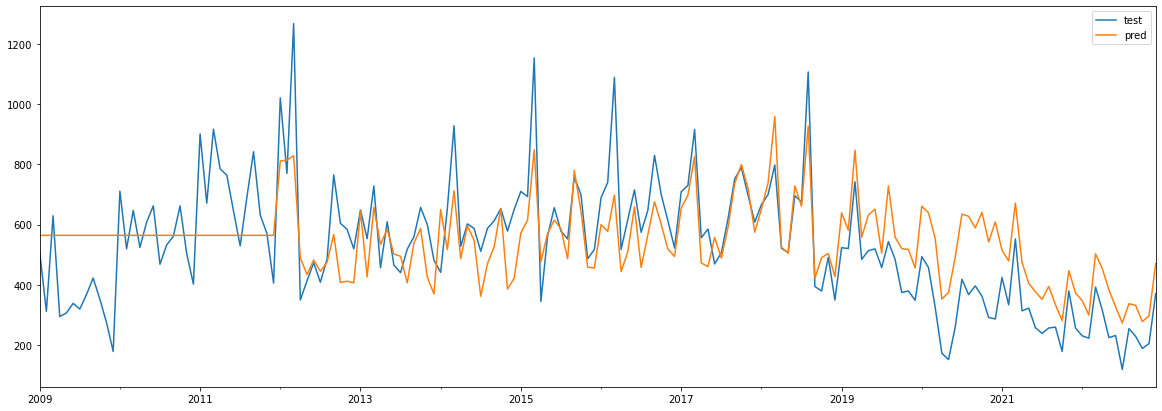

In [165]:
# Backtesting
from skforecast.model_selection import backtesting_forecaster

# Number of samples for backtest (14 y)
n_backtesting = 12*14

metric, backtest_pred = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = df[dep_var],
                                    exog               = df_exo,
                                    initial_train_size = len(df) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    refit              = True,
                                    metric             = 'mean_squared_error',
                                    verbose            = True
                                 )

print(f"Error de backtest: {metric}")

fig, ax = plt.subplots(figsize=(20, 7))
df.loc[backtest_pred.index, dep_var].plot(ax=ax, label='test')
backtest_pred.plot(ax=ax, label='predicciones')
ax.legend();

#### Feature importance

In [166]:
# Feature importance
feature_importance = forecaster.get_feature_importance().sort_values(by='importance', ascending=False)
feature_importance

,feature,importance
17,Orders_rolled_detrended,78
19,TIV_rolled_detrended,29
3,lag_4,24
0,lag_1,22
11,lag_12,22
8,lag_9,19
9,lag_10,19
1,lag_2,18
20,Unemployment_rate,18
6,lag_7,18


### Summary

In [167]:
metrics

,Extra Tree,XGBoost,Gradient Boosting,Random Forest,Ada Boost,LightGBM,Decision Tree,LGBMRegressor Tuned
Mean Absolute Error,232.704167,208.023033,198.108531,232.506667,236.235724,148.271213,213.416667,147.419470
Mean Squared Error,57865.275308,46708.659730,43326.374162,57455.868661,59753.257773,24755.711066,54184.805556,24603.113916
Root Mean Squared Error,240.552022,216.121863,208.149884,239.699538,244.444795,157.339477,232.776299,156.853798
R^2,-5.043658,-3.878421,-3.525162,-5.000898,-5.240845,-1.585576,-4.659256,-1.569638
Mean Absolute Percentage Error,91.590964,81.781675,77.158419,90.030873,93.099339,58.237573,85.258543,58.041924
Accuracy,8.409036,18.218325,22.841581,9.969127,6.900661,41.762427,14.741457,41.958076


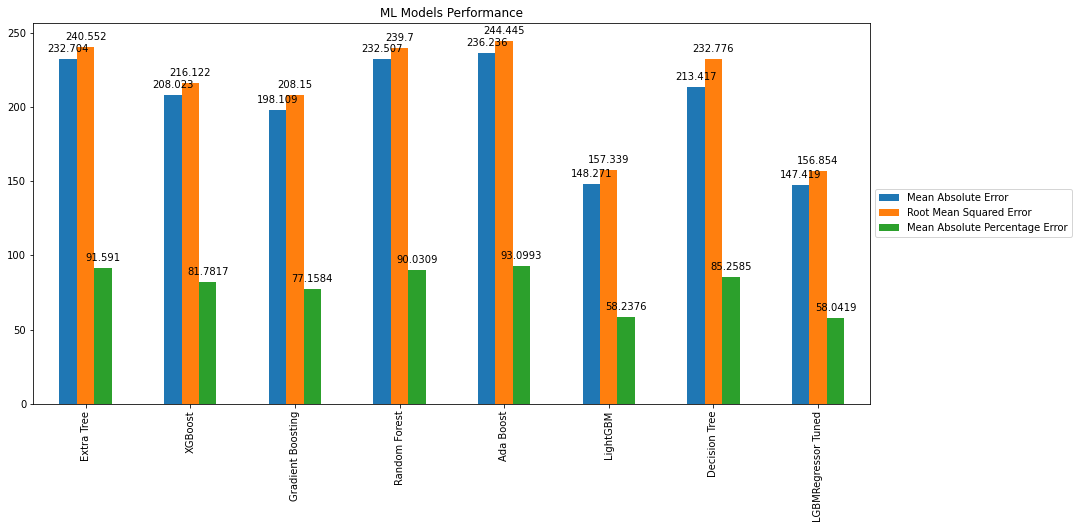

In [176]:
chart = metrics.transpose()
chart.drop(['Mean Squared Error', 'R^2', 'Accuracy'], axis=1, inplace=True)

ax = chart.plot.bar(title="ML Models Performance", figsize=(15,7))
for container in ax.containers:
    ax.bar_label(container, padding=5)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))